# Analysis of Gemma2-9B-it vs Claude3.5 on ARC Challenges

We'd like to compare Gemma2 and Claude3.5 performance on the ARC challenges versus the size and classification of those challenges.

Set means the number of elements in the test output matrix, the size of the amtrix we are trying to predict. Naturally, larger matrices will be more difficult with greater opportunity for error.

In [1]:
# set local working directory
import os

# set working directory
os.chdir("/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/MechInterp")
cwd = os.getcwd()
print(cwd)


/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/MechInterp


## Load Results from Execution

In [2]:
import pandas as pd

claude35 = pd.read_excel('claude35.xlsx')
gemma2 = pd.read_excel('gemma2.xlsx')


### Get Test Matrix Sizes (Number of Elements)

In [4]:
# get list of all files from folder

def get_json_files(folder_path):
    json_files = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            json_files.append(filename)
    return json_files

folder_path = '/home/oliver/Documents/LangChain/ProductDevelopment/AutoGen/ArcAGI/data/training/'

filenames = get_json_files(folder_path)

# view the results
filenames

['a64e4611.json',
 'aabf363d.json',
 '0ca9ddb6.json',
 '746b3537.json',
 '6150a2bd.json',
 '445eab21.json',
 '6aa20dc0.json',
 '913fb3ed.json',
 'af902bf9.json',
 '6a1e5592.json',
 '75b8110e.json',
 '5614dbcf.json',
 'f2829549.json',
 '54d9e175.json',
 '25d487eb.json',
 '5168d44c.json',
 '6d75e8bb.json',
 '0a938d79.json',
 '3befdf3e.json',
 '673ef223.json',
 'b91ae062.json',
 'd364b489.json',
 'b190f7f5.json',
 'ff28f65a.json',
 '1190e5a7.json',
 'b548a754.json',
 '97999447.json',
 'ce22a75a.json',
 '9565186b.json',
 'ea32f347.json',
 '6e82a1ae.json',
 '228f6490.json',
 '496994bd.json',
 'a68b268e.json',
 '60b61512.json',
 'b60334d2.json',
 '8be77c9e.json',
 '5521c0d9.json',
 'e8593010.json',
 '2281f1f4.json',
 '22233c11.json',
 'e9afcf9a.json',
 '8e5a5113.json',
 'b8cdaf2b.json',
 '90f3ed37.json',
 'f35d900a.json',
 '2204b7a8.json',
 'bc1d5164.json',
 '85c4e7cd.json',
 '810b9b61.json',
 'a2fd1cf0.json',
 '67a3c6ac.json',
 'ce9e57f2.json',
 'a48eeaf7.json',
 '4612dd53.json',
 '0d3d703e

In [5]:
import numpy as np
import json
import pandas as pd

df_gemma2_files = pd.read_parquet('df_combined.parquet')

# function to get size of a test matrix
def get_test_matrix(filename: str, input_or_output='output'):
    result = []
    with open(folder_path + filename, 'r') as file:
        dataset = json.load(file)

    test_actual = np.array(dataset['test'][0][input_or_output])
    cells = test_actual.shape[0] * test_actual.shape[1]

    return {'filename': filename, 'cells':cells, 'shape': test_actual.shape}

# execute function over all files in folder
test_sizes = []
for filename in filenames:
    
    input_size = get_test_matrix(filename, input_or_output='input')
    input_size['type']='input'
    test_sizes.append(input_size)

    output_size = get_test_matrix(filename, input_or_output='output')
    output_size['type']='output'
    test_sizes.append(output_size)

test_sizes = pd.DataFrame(test_sizes)

# Pivot
pivoted_df = test_sizes.pivot(index='filename', columns='type', values='cells')

# Rename the columns
pivoted_df.columns = ['test_size_' + col for col in pivoted_df.columns]

# Reset the index to make filename a column again
pivoted_df = pivoted_df.reset_index()

# view results
pivoted_df

,filename,test_size_input,test_size_output
0,00576224.json,4,36
1,007bbfb7.json,9,81
2,009d5c81.json,196,196
3,00d62c1b.json,400,400
4,00dbd492.json,400,400
...,...,...,...
398,fcb5c309.json,289,64
399,fcc82909.json,100,100
400,feca6190.json,5,400
401,ff28f65a.json,36,9


In [6]:
# We decide to use only the output size:
file_sizes = pivoted_df[['filename', 'test_size_output']]
file_sizes.columns = ['filename', 'cells']
file_sizes

,filename,cells
0,00576224.json,36
1,007bbfb7.json,81
2,009d5c81.json,196
3,00d62c1b.json,400
4,00dbd492.json,400
...,...,...
398,fcb5c309.json,64
399,fcc82909.json,100
400,feca6190.json,400
401,ff28f65a.json,9


In [7]:
def process_dataframe(df, file_sizes_df):
    """
    Process a dataframe by merging with file sizes, grouping by filename,
    and clipping similarity scores to 0 where less than 0. 
    Negatives similarity represents an error, eg output matrix shape not equal to target shape
    Hence similarity cannot be calculated.
    
    Parameters:
    df (pd.DataFrame): The input dataframe to process.
    file_sizes_df (pd.DataFrame): The dataframe containing file sizes.
    
    Returns:
    pd.DataFrame: Processed dataframe with filename, max similarity, and cells.
    """
    # Merge the input dataframe with file sizes
    df_with_cells = df.merge(file_sizes_df[['filename', 'cells']], on='filename', how='left')
    
    # Group by filename, get max similarity and first cells value
    result = df_with_cells.groupby('filename').agg({
        'similarity': 'max',
        'cells': 'first'
    }).reset_index()
    
    # Ensure minimum similarity is 0
    result['similarity'] = result['similarity'].clip(lower=0)
    
    # Reorder columns
    result = result[['filename', 'similarity', 'cells']]
    
    return result

In [8]:
claude35_for_chart = process_dataframe(claude35, file_sizes)
claude35_for_chart

,filename,similarity,cells
0,00576224.json,1.000000,36
1,007bbfb7.json,0.703704,81
2,009d5c81.json,0.867347,196
3,00d62c1b.json,0.000000,400
4,00dbd492.json,0.000000,400
...,...,...,...
398,fcb5c309.json,0.000000,64
399,fcc82909.json,0.960000,100
400,feca6190.json,0.000000,400
401,ff28f65a.json,1.000000,9


In [5]:
gemma2_for_chart = process_dataframe(gemma2, file_sizes)
gemma2_for_chart

,filename,similarity,cells
0,00576224.json,1.000000,36
1,007bbfb7.json,0.777778,81
2,009d5c81.json,0.867347,196
3,00d62c1b.json,0.915000,400
4,00dbd492.json,0.743750,400
...,...,...,...
398,fcb5c309.json,0.000000,64
399,fcc82909.json,0.820000,100
400,feca6190.json,0.000000,400
401,ff28f65a.json,1.000000,9


## Functions to Plot Similarity vs Size as Box Plots

We hypothesis that larger challenges are harder to predict.
Similarity is how closely the model predicted the target output.
The size is the size of the output.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_similarity_vs_cells_boxplot(df1=None, df2=None, label1='Series 1', label2='Series 2'):
    # Check if at least one dataframe is provided
    if df1 is None and df2 is None:
        raise ValueError("At least one dataframe must be provided")

    # Combine dataframes for easier plotting
    combined_df = pd.DataFrame()
    if df1 is not None:
        df1['series'] = label1
        combined_df = pd.concat([combined_df, df1])
    if df2 is not None:
        df2['series'] = label2
        combined_df = pd.concat([combined_df, df2])

    # Create cell ranges
    combined_df['cell_range'] = pd.cut(combined_df['cells'], bins=np.arange(0, 1001, 100))

    # Create the plot
    plt.figure(figsize=(15, 10))

    # Determine colors based on which series are present
    colors = []
    if df1 is not None:
        colors.append('lightblue')
    if df2 is not None:
        colors.append('lightpink')

    # Box plot with light colors
    sns.boxplot(x='cell_range', y='similarity', hue='series', data=combined_df, 
                palette=colors, width=0.6, fliersize=0)

    # Scatter plot with darker colors
    sns.stripplot(x='cell_range', y='similarity', hue='series', data=combined_df, 
                  dodge=True, alpha=0.5, jitter=True, 
                  palette=['blue' if 'lightblue' in colors else 'red' if 'lightpink' in colors else ''])

    # Customize the plot
    plt.xlabel('Cell Range')
    plt.ylabel('Similarity')
    plt.title('Similarity Distribution by Cell Range')
    plt.xticks(rotation=45)

    # Adjust legend
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title='Series')

    plt.tight_layout()
    plt.show()

/home/oliver/anaconda3/envs/LangChain311/lib/python3.11/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


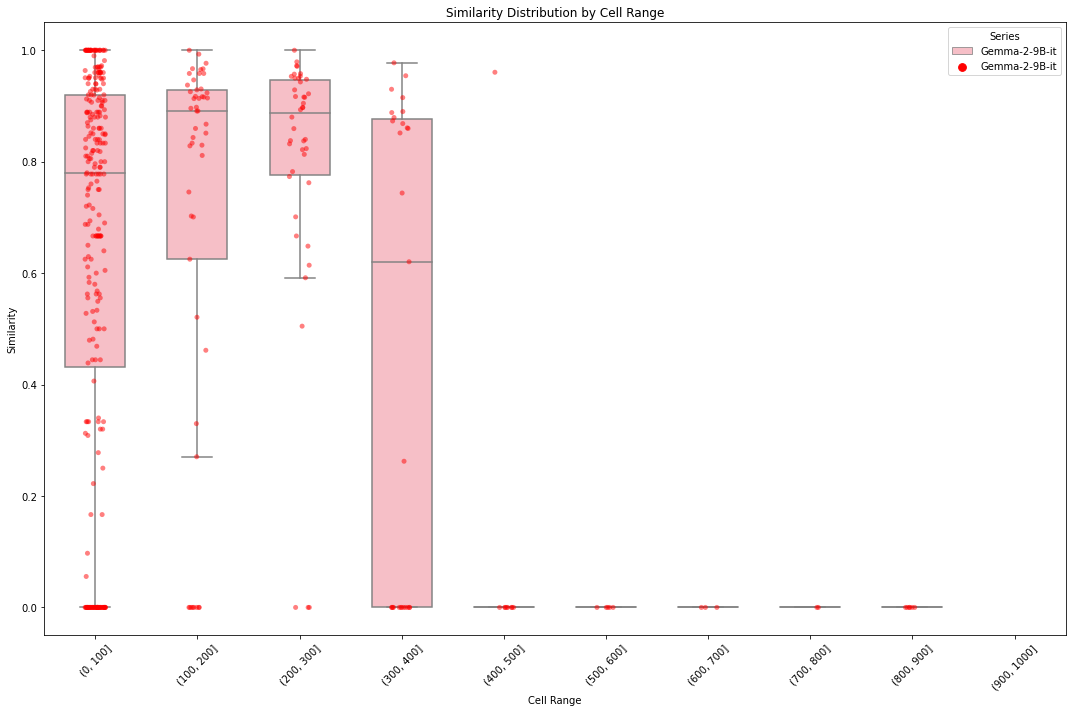

In [7]:
# Plot for Gemma2
plot_similarity_vs_cells_boxplot(None, gemma2_for_chart, None, label2='Gemma-2-9B-it')

/home/oliver/anaconda3/envs/LangChain311/lib/python3.11/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


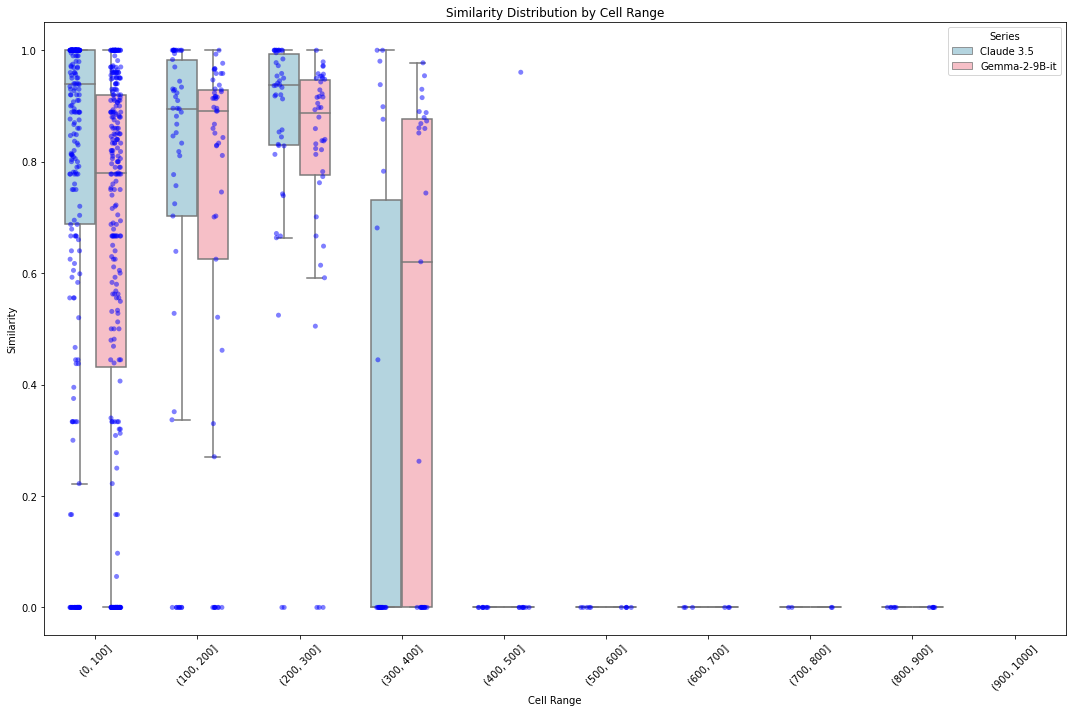

In [8]:
# Plot for Gemma2 and Claude35 Compared
plot_similarity_vs_cells_boxplot(claude35_for_chart, gemma2_for_chart, label1='Claude 3.5', label2='Gemma-2-9B-it')

## Analysing Impact of Classifications

Are some types of problems more difficult than others?

In [ ]:
# Get Data

challenge_classifications=pd.read_excel('ARC_classifications.xlsx')

combined_df = pd.concat([claude35_for_chart, gemma2_for_chart])
combined_df = combined_df.drop_duplicates()
combined_df = combined_df.merge(challenge_classifications, on='filename', how='left')


In [81]:
import pandas as pd
from typing import List, Dict, Tuple
from collections import Counter

def analyze_classifications_with_proportions(data: List[Dict]) -> Dict[str, List[Tuple[str, int, float]]]:
    df = pd.DataFrame(data)
    
    results = {}
    
    for model in df['model'].unique():
        model_df = df[df['model'] == model]
        
        # Filter for rows where classification_1 is not NaN
        model_df_classified = model_df[model_df['classification_1'].notna()]
        
        # Count total occurrences of each classification_1 value
        total_counts = Counter(model_df_classified['classification_1'])
        
        # Filter for rows where similarity is 1 and classification_1 is not NaN
        model_df_perfect = model_df[(model_df['similarity'] == 1) & (model_df['classification_1'].notna())]
        
        # Count occurrences of each classification_1 value for perfect scores
        perfect_counts = Counter(model_df_perfect['classification_1'])
        
        # Calculate proportions and create result tuples
        classifications = []
        for classification in total_counts.keys():
            total = total_counts[classification]
            perfect = perfect_counts.get(classification, 0)
            proportion = perfect / total if total > 0 else 0
            classifications.append((classification, perfect, proportion))
        
        # Sort classifications by perfect count in descending order
        sorted_classifications = sorted(classifications, key=lambda x: x[1], reverse=True)
        
        results[model] = sorted_classifications
    
    return results


In [82]:
# Assuming your data is in a variable called 'data'
result = analyze_classifications_with_proportions(combined_df)

for model, classifications in result.items():
    print(f"\nModel: {model}")
    if classifications:
        print("  Classification | Perfect Count | Proportion")
        print("  ---------------|---------------|------------")
        for classification, count, proportion in classifications:
            print(f"  {classification:<14} | {count:<13} | {proportion:.2%}")
    else:
        print("  No classifications found for this model.")


Model: Claude35
  Classification | Perfect Count | Proportion
  ---------------|---------------|------------
  grid expansion and repetition | 16            | 84.21%
  shape detection and transformation | 6             | 35.29%
  mathematical operations | 5             | 62.50%
  pattern propagation | 5             | 31.25%
  grid segmentation | 5             | 55.56%
  boundary detection and fill | 3             | 42.86%
  color/value substitution | 3             | 100.00%
  connectivity based transformations | 2             | 28.57%
  coordinate based transformations | 1             | 100.00%
  rule based transformation | 0             | 0.00%

Model: Gemma2
  Classification | Perfect Count | Proportion
  ---------------|---------------|------------
  grid expansion and repetition | 11            | 57.89%
  mathematical operations | 5             | 62.50%
  pattern propagation | 3             | 18.75%
  grid segmentation | 3             | 33.33%
  shape detection and transformation 

## Statistical Comparison of Claude3.5 Performance Using Various Approaches

To compare performance of the three approaches to the ARC challenges using Claude3.5:

- Estimate_1shot
    - Simple prompt and response
- Estimate_Agent
    - Agentic workflow to review each challenge and develop an answer by estimation.
- Coding_Agent
    - As above, but with added ability to write and execute code, an environment for 


In [30]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

def compare_methods(df):
    methods = ['Estimate_Agent', 'Estimate_1shot', 'Coding_Agent']
    results = {}

    for i in range(len(methods)):
        for j in range(i+1, len(methods)):
            method1 = methods[i]
            method2 = methods[j]
            
            # Create contingency table
            table = pd.crosstab(df[method1], df[method2])
            
            # Perform McNemar's test
            result = mcnemar(table, exact=False, correction=True)
            
            # Store results
            key = f"{method1} vs {method2}"
            results[key] = {
                'statistic': result.statistic,
                'p-value': result.pvalue,
                'contingency_table': table
            }

    return results


In [42]:
def print_results(results):
    print("""
Interpretation Guide:
1. McNemar's statistic: 
   - Higher values indicate greater disagreement between methods.
   - Values closer to 0 suggest similar performance.

2. p-value:
   - p < 0.05: Strong evidence of a significant difference between methods.
   - 0.05 <= p < 0.10: Marginal evidence of a difference.
   - p >= 0.10: Insufficient evidence to conclude a significant difference.

3. Odds Ratio (OR):
   - OR = 1: No difference between methods.
   - OR < 1: First mentioned method more likely to succeed where second fails.
   - OR > 1: Second mentioned method more likely to succeed where first fails.
   - |log2(OR)| > 1 (i.e., OR > 2 or OR < 0.5): Large effect size.

Note: Consider both statistical significance (p-value) and practical significance (effect size) when interpreting results.
    """)

    for comparison, result in results.items():
        method1, method2 = comparison.split(" vs ")
        print(f"\nComparison: {comparison}")
        print(f"McNemar's statistic: {result['statistic']:.4f}")
        print(f"p-value: {result['p-value']:.4f}")
        print("Contingency Table:")
        print(result['contingency_table'])
        
        # Calculate effect size (odds ratio)
        table = result['contingency_table']
        odds_ratio = (table.iloc[0,1] + 0.5) / (table.iloc[1,0] + 0.5)  # Adding 0.5 for Haldane-Anscombe correction
        print(f"Effect size (odds ratio): {odds_ratio:.4f}")
        
        print("\nInterpretation:")
        if result['p-value'] < 0.05:
            print(f"There is strong evidence of a statistically significant difference between {method1} and {method2} (p < 0.05).")
        elif result['p-value'] < 0.10:
            print(f"There is marginal evidence of a difference between {method1} and {method2} (0.05 <= p < 0.10).")
        else:
            print(f"There is insufficient evidence to conclude a statistically significant difference between {method1} and {method2} (p >= 0.10).")
        
        if odds_ratio < 1:
            print(f"{method1} is {1/odds_ratio:.2f} times more likely to succeed where {method2} fails.")
        else:
            print(f"{method2} is {odds_ratio:.2f} times more likely to succeed where {method1} fails.")
        
        if odds_ratio > 2 or odds_ratio < 0.5:
            print(f"The effect size is large and may be practically significant, regardless of statistical significance.")
        else:
            print(f"The effect size is relatively small, which may or may not be practically significant depending on the context.")
        

In [28]:
df_agentic_vs_1shot = pd.read_excel('assets/ARC_Outcomes_Claude35_AgenticVs1shot.xlsx')
df_agentic_vs_1shot


,filename,Estimate_Agent,Coding_Agent,Estimate_1shot
0,00576224.json,1,1,1
1,017c7c7b.json,1,1,1
2,178fcbfb.json,1,1,1
3,272f95fa.json,1,1,1
4,3af2c5a8.json,1,1,1
...,...,...,...,...
75,ae3edfdc.json,0,0,0
76,b775ac94.json,0,0,0
77,cce03e0d.json,0,0,0
78,d07ae81c.json,0,0,0


In [44]:
results = compare_methods(df_agentic_vs_1shot)
print_results(results)


Interpretation Guide:
1. McNemar's statistic: 
   - Higher values indicate greater disagreement between methods.
   - Values closer to 0 suggest similar performance.

2. p-value:
   - p < 0.05: Strong evidence of a significant difference between methods.
   - 0.05 <= p < 0.10: Marginal evidence of a difference.
   - p >= 0.10: Insufficient evidence to conclude a significant difference.

3. Odds Ratio (OR):
   - OR = 1: No difference between methods.
   - OR < 1: First mentioned method more likely to succeed where second fails.
   - OR > 1: Second mentioned method more likely to succeed where first fails.
   - |log2(OR)| > 1 (i.e., OR > 2 or OR < 0.5): Large effect size.

Note: Consider both statistical significance (p-value) and practical significance (effect size) when interpreting results.
    

Comparison: Estimate_Agent vs Estimate_1shot
McNemar's statistic: 1.8947
p-value: 0.1687
Contingency Table:
Estimate_1shot   0   1
Estimate_Agent        
0               38   6
1            